## Check the results on BXD data from all methods we have...

Objectives for this analysis:
1. Check the cases in which GEMMA may have performed badly...


2. For our current Bulkscan approach, even though it is fast, but theoretically it produces non-exact solutions. Thus, we need to: 
    - Check how different the Bulkscan results are compared with scan_alt results (assuming scan_alt gives the exact results)...
    
    - For those associations that are significant based on the exact solutions, can the Bulkscan solutions also find them?
    
3. Finally, we would explore the idea that combines finding the exact VC and the LiteQTL matrix multiplication approach, by grouping the traits with same or similar $h^2$ (from null) and perform matrix multiplication for each group (taken one group of multiple trait as a matrix).
    - Can this new idea beat bulkscan both in speed and accuracy?
   

### Preparation:

In [1]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test/notebooks"

In [2]:
cd("..")

In [3]:
Threads.nthreads()

24

In [4]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [5]:
using LoopVectorization
using Tables
using Test
using Plots
using ThreadTools

In [6]:
include("../src/scan_LiteQTL.jl"); ## Load multithreaded functions to be tested:

In [7]:
include("../src/parallel_helpers.jl");

In [8]:
kinship_Gc = CSV.read("run-gemma/output/kinship.cXX.txt", DataFrame, delim = '\t', header = false) |> Matrix;

### Get full results:

(for all 35k BXD traits) from GEMMA and scan_alt()

In [9]:
function get_LODs_from_alt(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    p = size(G, 2);
    
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, X0, lambda0) = rotateData(Y, [intercept G], K);
    
    lods_from_alt = Array{Float64, 2}(undef, p, m);
    hsqs_from_alt = Array{Float64, 2}(undef, p, m);

    intercept0 = reshape(X0[:, 1], :, 1);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        
        lod = zeros(p);
        hsqs = zeros(p);
        X = zeros(n, 2);
        X[:, 1] = X0[:, 1];
        
        for j in 1:p
            X[:, 2] = X0[:, j+1];
            
            out11 = fitlmm(y0_i, X, lambda0; reml = reml);
            
            hsqs[j] = out11.h2;
            lod[j] = (out11.ell - out00.ell)/log(10);
            
        end
        
        lods_from_alt[:, i] = lod;
        hsqs_from_alt[:, i] = hsqs;
        
    end
    
    return (hsqs_from_alt, lods_from_alt);
    
end

get_LODs_from_alt (generic function with 1 method)

In [10]:
# @time results_from_alt = get_LODs_from_alt(pheno, geno, kinship_Gc; reml = false);

In [11]:
# writedlm("hsqs_from_alt.csv", results_from_alt[1], ',');

In [12]:
# writedlm("lods_from_alt.csv", results_from_alt[2], ',');

In [13]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64";

Read the saved output files...

In [14]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test"

In [15]:
@time pvals_from_gemma = CSV.File("output/pvals_from_gemma.csv", header = false) |> Tables.matrix;

 15.643110 seconds (27.69 M allocations: 7.688 GiB, 13.56% gc time, 14.38% compilation time)


In [16]:
@time hsqs_from_gemma = CSV.File("output/hsqs_from_gemma.csv", header = false) |> Tables.matrix;

 12.285630 seconds (22.22 M allocations: 7.386 GiB, 7.99% gc time)


In [17]:
@time lods_from_gemma = CSV.File("output/lods_from_gemma.csv", header = false) |> Tables.matrix;

 13.584551 seconds (22.22 M allocations: 7.388 GiB, 22.67% gc time)


In [18]:
@time hsqs_from_alt = CSV.File("output/hsqs_from_alt.csv", header = false) |> Tables.matrix;

 12.034445 seconds (22.22 M allocations: 7.393 GiB, 19.39% gc time)


In [19]:
@time lods_from_alt = CSV.File("output/lods_from_alt.csv", header = false) |> Tables.matrix;

 13.121746 seconds (22.22 M allocations: 7.386 GiB, 26.98% gc time)


In [20]:
test = readdlm("run-gemma/output/gemma_results.txt.assoc.txt", '\t');

In [21]:
size(pvals_from_gemma) .== (p, m)

(true, true)

In [22]:
@testset "checkSavedResults" begin
    
    @test size(pvals_from_gemma, 1) == p && size(pvals_from_gemma, 2) == m;
    @test size(hsqs_from_gemma, 1) == p && size(hsqs_from_gemma, 2) == m;
    @test size(lods_from_alt, 1) == p && size(lods_from_alt, 2) == m;
    @test size(hsqs_from_alt, 1) == p && size(hsqs_from_alt, 2) == m;
    @test sum(hsqs_from_gemma[:, m] .== test[2:end, 9]) == p;
    @test sum(pvals_from_gemma[:, m] .== test[2:end, 10]) == p;
    
end;

Test Summary:     | Pass  Total
checkSavedResults |    6      6


### Compare results:

In [23]:
Threads.nthreads() # Number of julia threads using...

24

In [24]:
BLAS.get_num_threads() # Number of BLAS threads using...

8

In [25]:
BLAS.set_num_threads(24) # Number of BLAS threads using...

In [26]:
BLAS.get_num_threads() # Number of BLAS threads using...

24

In [27]:
grid_hsqs = collect(0:100).*0.01;

In [28]:
grid_hsqs = collect(0:10).*0.1;

In [29]:
@time lods_from_bulk = bulkscan(pheno, geno, kinship_Gc, grid_hsqs);

 15.734955 seconds (294.69 k allocations: 22.274 GiB, 12.75% gc time, 0.88% compilation time)


In [30]:
@time maxSqDiff(lods_from_bulk, lods_from_alt)

  1.048853 seconds (2 allocations: 1.939 GiB, 8.66% gc time)


7399.027333439694

In [31]:
any(lods_from_bulk .< 0)

false

In [32]:
any(lods_from_alt .< 0)

true

In [33]:
any(lods_from_gemma .< 0)

false

In [34]:
findmax(lods_from_bulk .- lods_from_alt)

(86.01759897509169, CartesianIndex(4753, 11077))

#### Compare bulkscan and scan_alt:

In [35]:
absDiff = abs.(lods_from_bulk .- lods_from_alt);
diffArray = vec(absDiff);

In [36]:
exactDiff = vec(lods_from_bulk .- lods_from_alt);

In [37]:
quantile(diffArray)

5-element Vector{Float64}:
  8.709608555201864e-12
  0.010031305531501541
  0.049906335306336154
  0.15410116200465496
 86.01759897509169

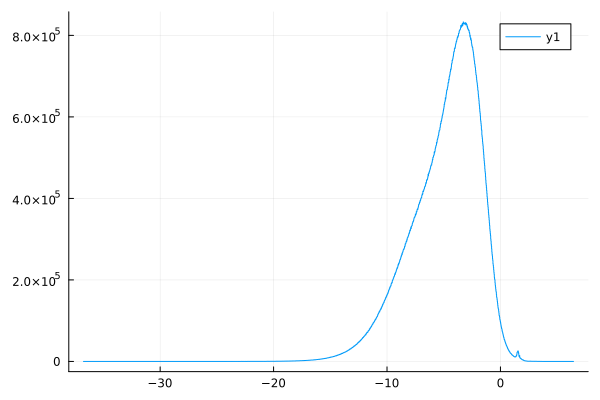

In [38]:
histogram(log2.(diffArray), binwidth = 1.0)

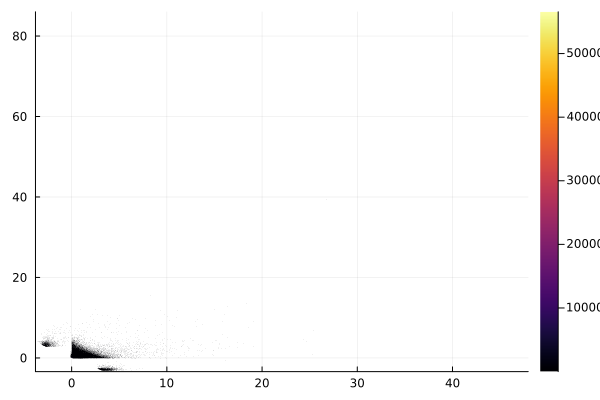

In [39]:
histogram2d(vec(lods_from_alt), exactDiff)

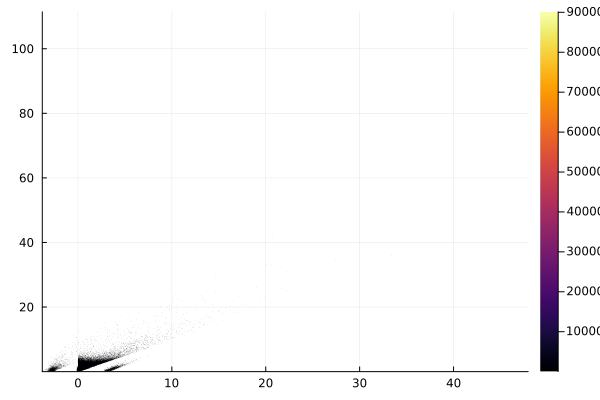

In [40]:
histogram2d(vec(lods_from_alt), vec(lods_from_bulk))

try hexbin...

Given a particular error tolerance, let's see how many the LOD scores estimated by our fast Bulkscan approach are within the acceptable error range:

#### Check negativity issue in lods_from_alt:

We see from the scatter plots, there are estimates of LOD scores that are negative, which is theoretically impossible. We now carefully examine how that happened in our outputs.

In [41]:
sum(lods_from_alt .< 0)/(m*p)

0.0007208108061468519

In [42]:
hasNegativeLODs = map(x -> any(lods_from_alt[:, x] .< 0), 1:m);
hasNegativeLODs_n1 = map(x -> any(lods_from_alt[:, x] .< -1.0), 1:m);

In [43]:
sum(hasNegativeLODs) # in total 386 (out of 35k) traits contain at least one negative LOD score.

386

In [44]:
sum(hasNegativeLODs_n1)

321

In [45]:
mean(hasNegativeLODs) # about 1% of the traits had negative LOD scores by scan_alt()

0.010856114298571268

Let's look at the first one...

In [46]:
blackSwans = findall(hasNegativeLODs); # traits that have at least one negative LOD

In [47]:
blackSwans_n1 = findall(hasNegativeLODs_n1); # traits that have at least one negative LOD

In [48]:
blackSwans

386-element Vector{Int64}:
    33
   108
   187
   222
   227
   258
   536
   544
   703
   712
   789
   821
   929
     ⋮
 34309
 34363
 34507
 34600
 34602
 34603
 34735
 34766
 35184
 35235
 35268
 35496

In [49]:
blackSwans_n1

321-element Vector{Int64}:
   108
   187
   222
   258
   536
   703
   712
   789
   929
   946
  1123
  1292
  1310
     ⋮
 34153
 34309
 34363
 34507
 34600
 34602
 34603
 34735
 34766
 35184
 35268
 35496

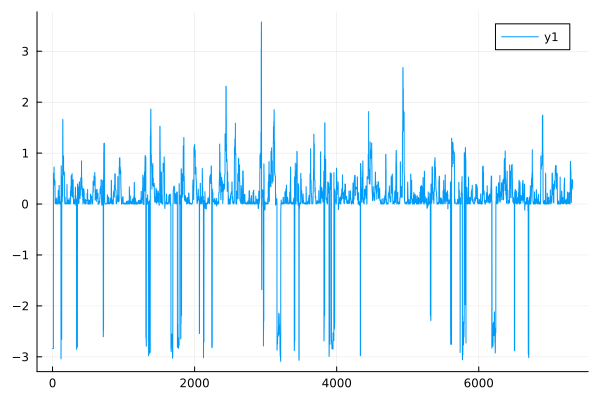

In [50]:
plot(lods_from_alt[:, 187])

In [51]:
test = scan_alt(reshape(pheno[:, 187], :, 1), geno, kinship_Gc; reml = false);

In [52]:
test[1]

0.132860815624458

In [53]:
test[2]

0.999999984947842

In [54]:
test[3]

7321-element Vector{Float64}:
 0.8993482584452811
 0.8993482584502311
 0.8993482581348059
 0.8993482581348059
 0.8993482414957287
 0.899348258420209
 0.8993482448879322
 0.8993482448879322
 0.8993482581348059
 0.8993482581348059
 0.8993482593459767
 0.8993616160814517
 0.999999984947842
 ⋮
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842

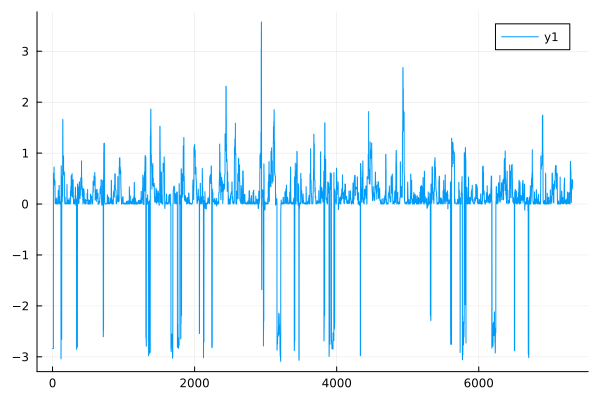

In [55]:
plot(scan_alt(reshape(pheno[:, 187], :, 1), geno, kinship_Gc; reml = false)[4])

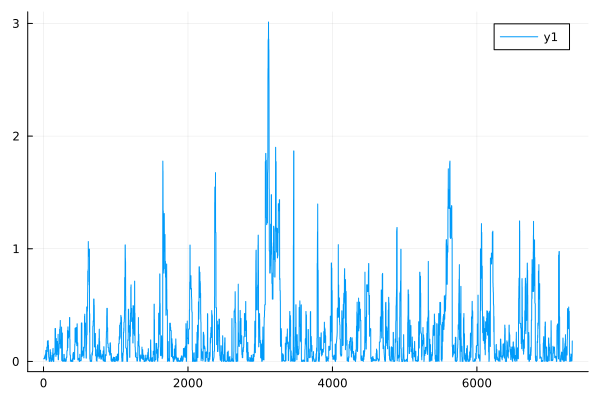

In [56]:
plot(lods_from_alt[:, 33])

In [57]:
firstBlackSwan = lods_from_alt[:, blackSwans[1]];

In [58]:
findall(firstBlackSwan .< 0)

4-element Vector{Int64}:
 853
 854
 855
 856

In [59]:
## Look at the corresponding hsqs:
map(x -> hsqs_from_alt[x, 33], findall(firstBlackSwan .< 0))

4-element Vector{Float64}:
 2.8889603743499245e-13
 2.8889603743499245e-13
 2.736462543444906e-13
 2.736462543444906e-13

In [60]:
bs_results_hsqs = Array{Array{Float64, 1}, 1}(undef, length(blackSwans));
bs_results_markers = Array{Array{Int, 1}, 1}(undef, length(blackSwans));
counter = 1;

for bs in blackSwans
    
    bs_lods = lods_from_alt[:, bs];
    bs_markers = findall(bs_lods .< 0);
    bs_hsqs = map(x -> hsqs_from_alt[x, bs], bs_markers);
    bs_results_hsqs[counter] = bs_hsqs;
    bs_results_markers[counter] = bs_markers;
    counter = counter + 1;
    
end

In [61]:
vec_bs_results_hsqs = [];
for x in bs_results_hsqs
    vec_bs_results_hsqs = vcat(vec_bs_results_hsqs, x);
end

In [62]:
vec_bs_results_markers = [];
for x in bs_results_markers
    vec_bs_results_markers = vcat(vec_bs_results_markers, x);
end

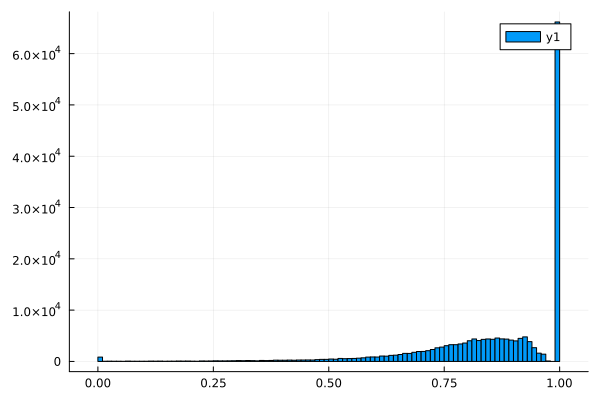

In [63]:
histogram(vec_bs_results_hsqs)

In [64]:
test_lods_K = scan_alt(reshape(pheno[:, 33], :, 1), geno, kinship; reml = false)[4];

In [65]:
test_lods_KGc = scan_alt(reshape(pheno[:, 33], :, 1), geno, kinship_Gc; reml = false)[4];

In [66]:
sumSqDiff(reshape(test_lods_KGc, :, 1), reshape(test_lods_K, :, 1))

1.2994834494907659

In [67]:
any(test_lods_KGc .< 0)

false

In [68]:
any(test_lods_K .< 0)

true

In [69]:
sumSqDiff(reshape(test_lods_KGc, :, 1), reshape(lods_from_alt[:, 33], :, 1))

1.8515786307649385e-24

In [70]:
sumSqDiff(reshape(test_lods_K, :, 1), reshape(lods_from_alt[:, 33], :, 1))

1.2994834494901637

In [71]:
any(lods_from_alt[:, 33] .< 0)

true

In [72]:
bs_results_hsqs[1]

4-element Vector{Float64}:
 2.8889603743499245e-13
 2.8889603743499245e-13
 2.736462543444906e-13
 2.736462543444906e-13

In [73]:
bs_results_markers[1]

4-element Vector{Int64}:
 853
 854
 855
 856

In [74]:
test_lods_K[856]

-6.1716957859410366e-15

But, are they all very small (negative but very close to 0)?

In [75]:
negativeLods = [];

for j in 1:p
    for i in 1:m
        if lods_from_alt[j, i] < 0
            append!(negativeLods, lods_from_alt[j, i]);
        else
            continue;
        end
    end
end     

In [76]:
negativeLods_n1 = [];

for j in 1:p
    for i in 1:m
        if lods_from_alt[j, i] < -1.0
            append!(negativeLods_n1, lods_from_alt[j, i]);
        else
            continue;
        end
    end
end  

In [77]:
length(negativeLods)

187631

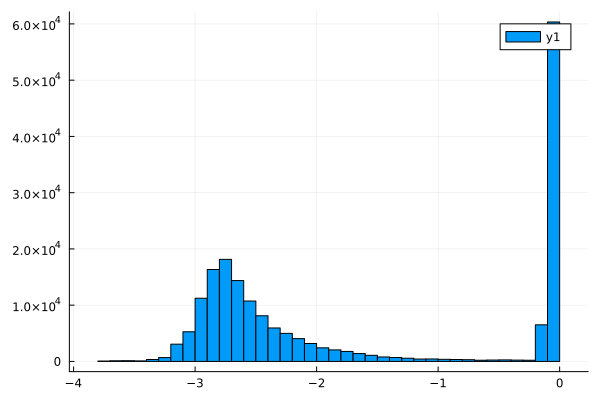

In [78]:
histogram(negativeLods)

In [79]:
negativeLods

187631-element Vector{Any}:
 -2.8364198415233637
 -2.3218522154526453
 -2.7159556629889297
 -2.1721973365984493
 -2.264965511150842
 -2.542476243814359
 -2.710494876228621
 -1.1697774413762279
 -2.7938726506943405
 -1.8205130845275086
 -2.293762921721445
 -2.6860082921356594
 -2.9593111257339486
  ⋮
 -0.007686738723658984
 -0.04020926181499682
 -2.562435531364291
 -2.967028433905106
 -2.8673702255188362
 -0.09970799532808765
 -0.05420349375631247
 -0.015245481757609283
 -0.1436970021656976
 -0.014311908993334564
 -2.458421773014684
 -0.02427366860169513

In [80]:
sum(negativeLods .< -1)/(p*m)

0.0004554802373807918

In [81]:
findfirst(lods_from_alt .< -1.0)

CartesianIndex(229, 108)

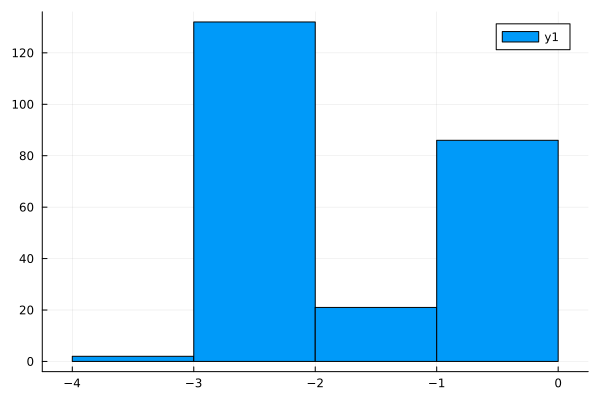

In [82]:
histogram(lods_from_alt[lods_from_alt[:, 108] .< 0, 108])

In [83]:
tol = 1.0;

In [84]:
sum(diffArray .<= tol)/length(diffArray)

0.9884312114893811

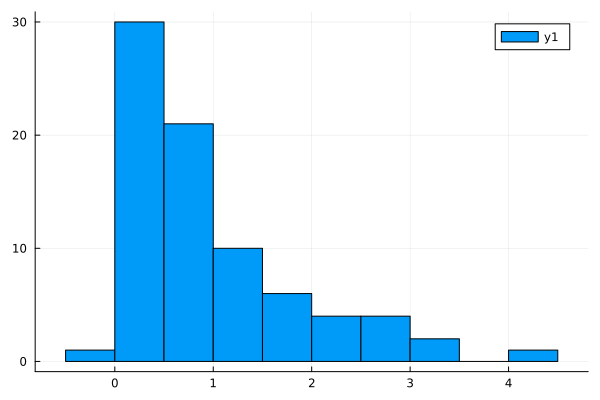

In [85]:
histogram(eigen(kinship_Gc).values)

In [86]:
test[4] # from scan_alt(kinship_Gc)

7321-element Vector{Float64}:
 -2.836419834316946
 -2.836419834316952
 -2.836419834316952
 -2.836419834316952
 -2.836419834316952
 -2.836419834316946
 -2.836419834316946
 -2.836419834316946
 -2.836419834316952
 -2.836419834316952
 -2.836419833599363
 -2.8364120623679985
  0.6033791659636699
  ⋮
  0.30170431232257705
  0.30170431266924735
  0.30170431266924735
  0.3719390973072517
  0.2909953718521782
  0.2909953718521782
  0.48298676948780855
  0.4066473087217643
  0.4152662994368362
  0.32721674326049227
  0.4661009363208286
  0.4661009363208286

In [87]:
test_bulk = scan_alt(reshape(pheno[:, 108], :, 1), geno, kinship; reml = false);

In [88]:
kinship

79×79 Matrix{Float64}:
 1.0       0.468763  0.561085  0.521296  …  0.567302  0.413471  0.435604
 0.468763  1.0       0.482652  0.50435      0.519167  0.532541  0.488972
 0.561085  0.482652  1.0       0.374733     0.622687  0.450508  0.453984
 0.521296  0.50435   0.374733  1.0          0.431956  0.469879  0.421972
 0.502617  0.431553  0.443817  0.577574     0.494489  0.51971   0.489528
 0.476443  0.483647  0.567154  0.462847  …  0.491136  0.512453  0.549432
 0.467349  0.501111  0.520678  0.527738     0.527077  0.481474  0.51916
 0.542558  0.60105   0.506142  0.463404     0.554531  0.498891  0.479556
 0.591896  0.403189  0.533654  0.425491     0.543941  0.448744  0.532008
 0.441302  0.626432  0.535918  0.447991     0.551656  0.450761  0.461508
 0.460209  0.457172  0.460111  0.489766  …  0.493009  0.494999  0.538533
 0.507042  0.570832  0.536868  0.614983     0.499858  0.503124  0.478369
 0.582008  0.544672  0.516424  0.492132     0.452945  0.45013   0.442422
 ⋮                           

In [89]:
any(eVals_gemma .< 0)

LoadError: UndefVarError: eVals_gemma not defined

In [90]:
eVals_bulk = eigen(kinship).values;
eVals_gemma = eigen(kinship_Gc).values;

In [91]:
det(kinship)

3.1022877513772875e-36

In [92]:
eVals2_bulk = reverse((svd(kinship).S) .^2);

In [93]:
?svd

search: svd svd! SVD svdvals svdvals! GeneralizedSVD isvalid CholeskyPivoted



```
svd(A; full::Bool = false, alg::Algorithm = default_svd_alg(A)) -> SVD
```

Compute the singular value decomposition (SVD) of `A` and return an `SVD` object.

`U`, `S`, `V` and `Vt` can be obtained from the factorization `F` with `F.U`, `F.S`, `F.V` and `F.Vt`, such that `A = U * Diagonal(S) * Vt`. The algorithm produces `Vt` and hence `Vt` is more efficient to extract than `V`. The singular values in `S` are sorted in descending order.

Iterating the decomposition produces the components `U`, `S`, and `V`.

If `full = false` (default), a "thin" SVD is returned. For a $M \times N$ matrix `A`, in the full factorization `U` is `M \times M` and `V` is `N \times N`, while in the thin factorization `U` is `M \times K` and `V` is `N \times K`, where `K = \min(M,N)` is the number of singular values.

If `alg = DivideAndConquer()` a divide-and-conquer algorithm is used to calculate the SVD. Another (typically slower but more accurate) option is `alg = QRIteration()`.

!!! compat "Julia 1.3"
    The `alg` keyword argument requires Julia 1.3 or later.


# Examples

```jldoctest
julia> A = rand(4,3);

julia> F = svd(A); # Store the Factorization Object

julia> A ≈ F.U * Diagonal(F.S) * F.Vt
true

julia> U, S, V = F; # destructuring via iteration

julia> A ≈ U * Diagonal(S) * V'
true

julia> Uonly, = svd(A); # Store U only

julia> Uonly == U
true
```

---

```
svd(A, B) -> GeneralizedSVD
```

Compute the generalized SVD of `A` and `B`, returning a `GeneralizedSVD` factorization object `F` such that `[A;B] = [F.U * F.D1; F.V * F.D2] * F.R0 * F.Q'`

  * `U` is a M-by-M orthogonal matrix,
  * `V` is a P-by-P orthogonal matrix,
  * `Q` is a N-by-N orthogonal matrix,
  * `D1` is a M-by-(K+L) diagonal matrix with 1s in the first K entries,
  * `D2` is a P-by-(K+L) matrix whose top right L-by-L block is diagonal,
  * `R0` is a (K+L)-by-N matrix whose rightmost (K+L)-by-(K+L) block is          nonsingular upper block triangular,

`K+L` is the effective numerical rank of the matrix `[A; B]`.

Iterating the decomposition produces the components `U`, `V`, `Q`, `D1`, `D2`, and `R0`.

The generalized SVD is used in applications such as when one wants to compare how much belongs to `A` vs. how much belongs to `B`, as in human vs yeast genome, or signal vs noise, or between clusters vs within clusters. (See Edelman and Wang for discussion: https://arxiv.org/abs/1901.00485)

It decomposes `[A; B]` into `[UC; VS]H`, where `[UC; VS]` is a natural orthogonal basis for the column space of `[A; B]`, and `H = RQ'` is a natural non-orthogonal basis for the rowspace of `[A;B]`, where the top rows are most closely attributed to the `A` matrix, and the bottom to the `B` matrix. The multi-cosine/sine matrices `C` and `S` provide a multi-measure of how much `A` vs how much `B`, and `U` and `V` provide directions in which these are measured.

# Examples

```jldoctest
julia> A = randn(3,2); B=randn(4,2);

julia> F = svd(A, B);

julia> U,V,Q,C,S,R = F;

julia> H = R*Q';

julia> [A; B] ≈ [U*C; V*S]*H
true

julia> [A; B] ≈ [F.U*F.D1; F.V*F.D2]*F.R0*F.Q'
true

julia> Uonly, = svd(A,B);

julia> U == Uonly
true
```


In [94]:
sVals2_bulk = reverse((svd(kinship).S));

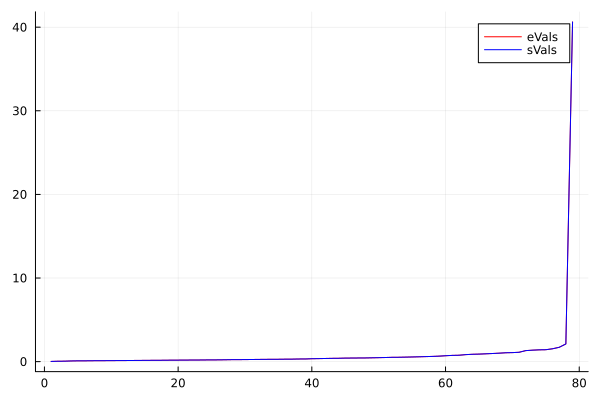

In [95]:
plot(eVals_bulk, color = "red", label = "eVals")
plot!(sVals2_bulk, color = "blue", label = "sVals")

In [96]:
eVals2_gemma = reverse((svd(kinship_Gc).S) .^2);

In [97]:
sVals_gemma = reverse((svd(kinship_Gc).S));

In [98]:
det(kinship_Gc)

-3.66729325945062e-26

In [99]:
minimum(eVals_bulk)

0.021444359161284423

In [100]:
minimum(eVals_gemma)

-2.637719172951642e-12

In [101]:
minimum(eVals2_gemma)

6.960079034703629e-24

In [102]:
sumSqDiff(reshape(sVals_gemma, :, 1), reshape(eVals_gemma, :, 1))

2.783540015219075e-23

In [103]:
Symmetric(kinship_Gc)

79×79 Symmetric{Float64, Matrix{Float64}}:
  0.971367    -0.0803409   0.118316    …  -0.219202    -0.174852
 -0.0803409    0.991482   -0.0287038       0.028784    -0.0582696
  0.118316    -0.0287038   1.01951        -0.12127     -0.114234
  0.0516335    0.0275875  -0.217635       -0.0696312   -0.165361
 -0.00965022  -0.141933   -0.103393        0.00610493  -0.0541761
 -0.0889471   -0.0646924   0.116334    …  -0.0353577    0.0386856
 -0.0566745    0.0206949   0.0738428      -0.0468544    0.028601
  0.057217     0.184047    0.00824396     -0.0485473   -0.0871337
  0.175272    -0.192295    0.0826458      -0.129463     0.0371489
 -0.139584     0.240522    0.0735055      -0.139098    -0.117519
 -0.0877774   -0.0840052  -0.0641144   …  -0.0366286    0.050524
 -0.0151781    0.122247    0.0683334      -0.0414448   -0.09087
  0.135896     0.0710691   0.0285863      -0.146292    -0.161624
  ⋮                                    ⋱               
 -0.00741148  -0.133136   -0.126767       -0.0603405

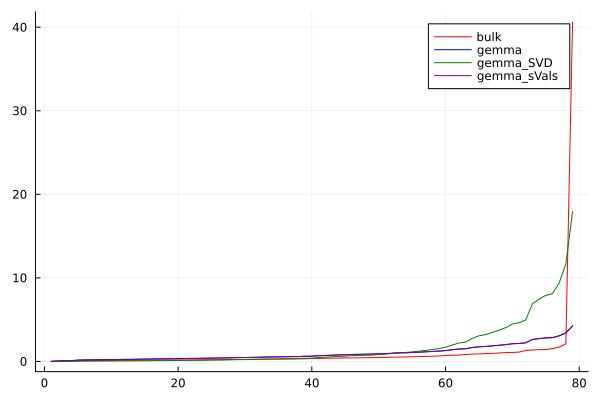

In [104]:
plot(eVals_bulk, color = "red", label = "bulk")
plot!(eVals_gemma, color = "blue", label = "gemma")
plot!(eVals2_gemma, color = "green", label = "gemma_SVD")
plot!(sVals_gemma, color = "purple", label = "gemma_sVals")

In [105]:
eigen(kinship_Gc' * kinship_Gc).values

79-element Vector{Float64}:
 -2.937172310768225e-16
  0.0017846601209840192
  0.0070696914212225225
  0.00955804231026898
  0.023695116160576735
  0.031899672775445496
  0.034405881930145835
  0.04098858291617475
  0.045931670534153056
  0.049042996261221244
  0.05311795479554986
  0.05943600120814023
  0.06261951968692833
  ⋮
  3.739115018938942
  4.046061736456523
  4.476315389967238
  4.629940371750789
  4.969325147960581
  6.909305324596259
  7.463945456548295
  7.912969477066619
  8.104258899151562
  9.406534614043615
 11.676883026340304
 17.948191334131334

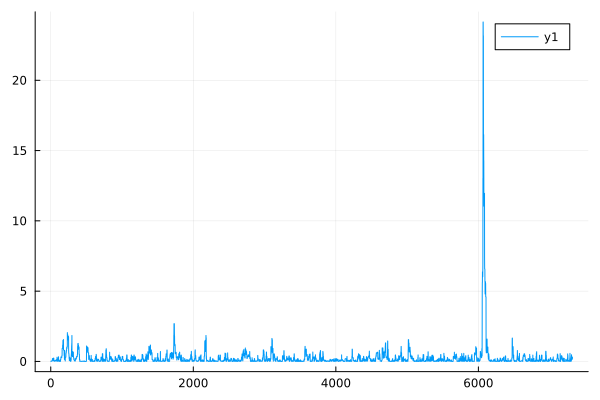

In [106]:
plot(test_bulk[4]) # with BulkLMM.calcKinship

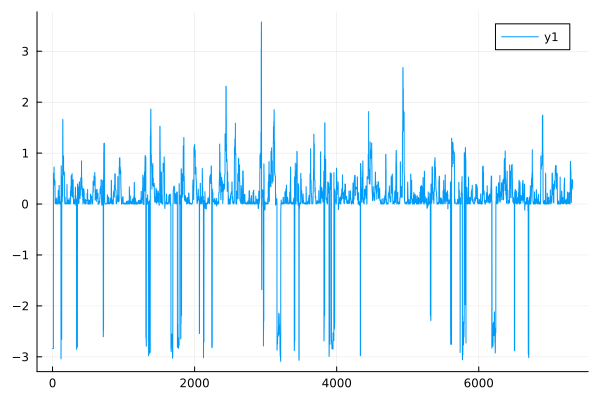

In [107]:
plot(test[4])

In [109]:
(U, S, V) = svd(kinship);

In [111]:
size(V)

(79, 79)

In [404]:
M = [1 0 0; 0 1 0; 0 2 1]

3×3 Matrix{Int64}:
 1  0  0
 0  1  0
 0  2  1

In [405]:
reverse(M; dims = 2)

3×3 Matrix{Int64}:
 0  0  1
 0  1  0
 1  2  0

In [454]:
function rotateData_SVD(Y::Array{Float64, 2}, X::Array{Float64, 2}, K::Array{Float64, 2})
    
        # check dimensions
        n = size(Y, 1)
        
        if( ( size(X,1) != n ) | ( size(K,1) != n ))
            error("Dimension mismatch.")
        end

        # spectral decomposition of a symmetric matrix
        SVD = svd(K);
        # EF = eigen(K);
        # Ut = reverse(SVD.Vt; dims = 1);
        Ut = reverse(SVD.U; dims = 2)';
    
        # return rotated phenotype, covariates, and eigenvalues
        return Ut*Y, Ut*X, reverse(SVD.S)  
        # return EF.vectors'*Y, EF.vectors'*X, reverse(S)
    
end

rotateData_SVD (generic function with 1 method)

In [455]:
function get_LODs_from_alt_SVD(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    p = size(G, 2);
    
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, X0, lambda0) = rotateData_SVD(Y, [intercept G], K);
    
    lods_from_alt = Array{Float64, 2}(undef, p, m);
    hsqs_from_alt = Array{Float64, 2}(undef, p, m);

    intercept0 = reshape(X0[:, 1], :, 1);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        
        lod = zeros(p);
        hsqs = zeros(p);
        X = zeros(n, 2);
        X[:, 1] = X0[:, 1];
        
        for j in 1:p
            X[:, 2] = X0[:, j+1];
            
            out11 = fitlmm(y0_i, X, lambda0; reml = reml);
            
            hsqs[j] = out11.h2;
            lod[j] = (out11.ell - out00.ell)/log(10);
            
        end
        
        lods_from_alt[:, i] = lod;
        hsqs_from_alt[:, i] = hsqs;
        
    end
    
    return (hsqs_from_alt, lods_from_alt);
    
end

get_LODs_from_alt_SVD (generic function with 1 method)

In [456]:
a = eigen(kinship_Gc);

In [457]:
b = svd(kinship_Gc);

In [458]:
sumSqDiff(reshape(a.values, :, 1), reshape(reverse(b.S), :, 1))

2.783540015219075e-23

In [459]:
sumSqDiff(kinship_Gc, a.vectors * diagm(a.values) *a.vectors')

1.2622099419536034e-26

In [460]:
sumSqDiff(kinship_Gc, reverse(b.U; dims = 2) * diagm(reverse(b.S)) * reverse(b.Vt; dims = 1))

5.995365362670453e-28

In [461]:
test_EF = get_LODs_from_alt(reshape(pheno[:, 108], :, 1), geno, kinship_Gc; reml = false);
test_SVD = get_LODs_from_alt_SVD(reshape(pheno[:, 108], :, 1), geno, kinship_Gc; reml = false);

In [462]:
lambda_EF = rotateData(reshape(pheno[:, 108], :, 1), geno, kinship_Gc);
lambda_SVD = rotateData_SVD(reshape(pheno[:, 108], :, 1), geno, kinship_Gc);

In [463]:
any(lambda_EF[3] .< 0)

true

In [464]:
any(lambda_SVD[3] .< 0)

false

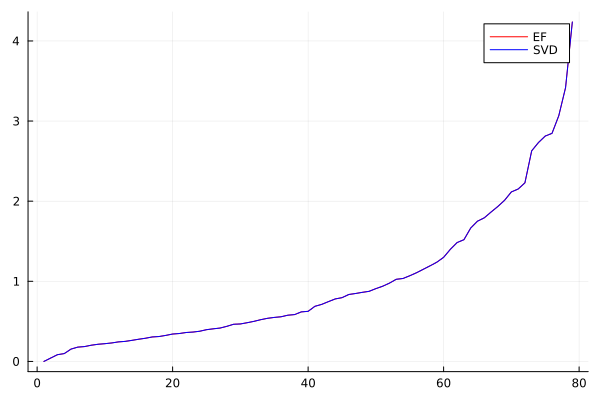

In [465]:
plot(lambda_EF[3], color = "red", label = "EF")
plot!(lambda_SVD[3], color = "blue", label = "SVD")

In [466]:
sumSqDiff(lambda_EF[2], lambda_SVD[2])

254161.6564821258

In [467]:
sumSqDiff(reshape(lambda_EF[3], :, 1), reshape(lambda_SVD[3], :, 1))

2.783540015219075e-23

In [468]:
any(test_EF[2] .< 0)

true

In [469]:
any(test_SVD[2] .< 0)

true

In [470]:
test_tab = hcat(test_EF[2], test_SVD[2], lods_from_gemma[:, 108])

7321×3 Matrix{Float64}:
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.0219153  0.0219153  0.0219155
 0.021912   0.021912   0.0219122
 0.0567256  0.0567256  0.0567251
 ⋮                     
 0.248678   0.248678   0.248678
 0.248678   0.248678   0.248678
 0.248678   0.248678   0.248678
 0.0686881  0.0686881  0.0686887
 0.124881   0.124881   0.124882
 0.124881   0.124881   0.124882
 0.249213   0.249213   0.249213
 0.273645   0.273645   0.273645
 0.271594   0.271594   0.271594
 0.285893   0.285893   0.285893
 0.229505   0.229505   0.229504
 0.229505   0.229505   0.229504

In [471]:
findfirst(test_tab .< 0)

CartesianIndex(229, 1)

In [472]:
test_tab[229, :]

3-element Vector{Float64}:
 -2.287303632407237
 -2.2872275203737553
  0.7365456112208408

#### Compare bulkscan and gemma:

Let's first convert the GEMMA logP to LOD scores:

In [71]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

p2lod (generic function with 1 method)

In [80]:
# @time lods_from_gemma = tmap(x -> p2lod(x, 1), pvals_from_gemma);

4946.602724 seconds (1.82 G allocations: 128.005 GiB, 66.84% gc time, 0.03% compilation time)


In [93]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test"

In [94]:
# @time writedlm("output/lods_from_gemma.csv", lods_from_gemma, ',');

 83.903268 seconds (520.68 M allocations: 109.592 GiB, 16.56% gc time, 0.05% compilation time)


In [109]:
function checkNaNTraits(L::Array{Float64, 2})
    
    hasNaN = mapslices(x -> any(isnan.(x)), L, dims = 1);
    return hasNaN;
    
end

checkNaNTraits (generic function with 1 method)

In [116]:
hasNaN = checkNaNTraits(lods_from_gemma)

1×35556 Matrix{Bool}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0

In [117]:
m - sum(hasNaN)

31923

In [92]:
sum(isnan.(lods_from_bulk))

0

In [119]:
sub_L_gemma = lods_from_gemma[:, .!vec(test)]

7321×31923 Matrix{Float64}:
 0.000120008  0.00296458  0.0161317   …  0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317   …  0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317      0.0472253   0.177029     0.348691
 0.000120008  0.00296458  0.0161317   …  0.0472253   0.177029     0.348691
 0.000119929  0.00296488  0.0161312      0.0472258   0.177038     0.348693
 0.00953411   0.017988    0.00472361     0.0558368   0.359087     0.3863

In [120]:
sub_L_bulk = lods_from_bulk[:, .!vec(test)];

In [127]:
any(isnan.(sub_L_gemma))

false

In [128]:
any(isnan.(absDiff_withGemma))

false

In [129]:
absDiff_withGemma = abs.(sub_L_bulk .- sub_L_gemma);
diffArray_withGemma = vec(absDiff_withGemma);

In [130]:
quantile(diffArray_withGemma)

5-element Vector{Float64}:
   1.245813953301006e-10
   0.009011057827680191
   0.04779152951479171
   0.1527810090113279
 NaN

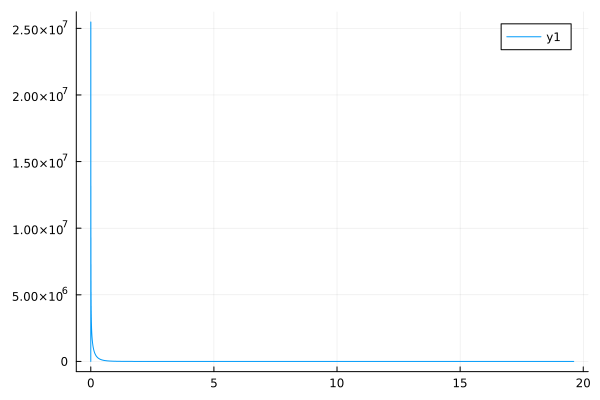

In [126]:
histogram(diffArray_withGemma, binwidth = 1.0)

In [124]:
sum(diffArray_withGemma .<= tol)/length(diffArray_withGemma)

0.9888348629902861

## Explore the binning idea:

### Compute null hsqs for every trait:

In [10]:
BLAS.set_num_threads(1)

In [11]:
function get_hsqs_from_null(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = true)

    (n, m) = size(Y);
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, intercept0, lambda0) = rotateData(Y, intercept, K);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null (generic function with 1 method)

In [16]:
@time hsqs_from_null = get_hsqs_from_null(pheno, kinship_Gc; reml = true);

 12.457308 seconds (31.89 M allocations: 12.694 GiB, 14.39% gc time)


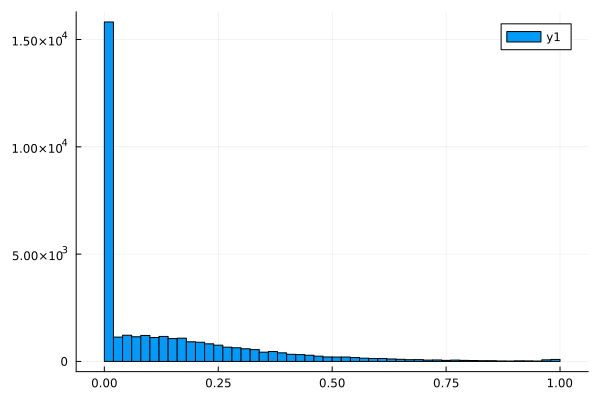

In [20]:
histogram(hsqs_from_null)

In [21]:
findall(hsqs_from_null .> 0.90)

239-element Vector{Int64}:
   536
   712
  1292
  1558
  1634
  2571
  2886
  3069
  3268
  3403
  3446
  3745
  3950
     ⋮
 32890
 32955
 33026
 33160
 33310
 33458
 34153
 34344
 34507
 34735
 34766
 35268

In [19]:
hsqs_from_null[7919]

0.8182834272313365

In [ ]:
function groupTraits(m::Int64, listHsq::Array{Float64, 1}, quantileHsq::Array{Float64, 2})
    
    
    
    
end